# Classifiers for What's Cooking

This file implements the following classifiers for the What's Cooking challenge, in an attempt to match the accuracy benchmarks noted below, from Ghewani-Raiyani (ref 1 in our brief):

**KNN** - 60.75% <br>
**Decision Tree** - 62.59% <br>
**Naive Bayes** - 73.25% <br>
**Random Forest** 74.13%  with an accuracy of the second paper claims accuracy of 76.2% using diff features. <br> 
**Logistic Regression** - 81.25% <br>
**SVM** - 81.32% <br>

Note that as labels for the test set are not available, the above benchmarks represent accuracy on the validation set. 

## Exec Summary

At present the analysis shows that even using a very simplistic pipeline featuring a CountVectorizer on the untransformed read-in data followed by un-tuned classifiers we can achieve results within 4ppts of the benchmarks, as tested on a single validation fold. 

## Further Work

1. I believe the greatest results will be achieved by improving the feature selection stage. At present the vectoriser selects individual words (so 'ground black pepper' would count towards each of the 'ground','black' and 'pepper' tokens) and there has been no modification done on the ingredients. Automated approaches could look at reducing number of features, concatenating, combining phrases with a high degree similarity etc. Manual approaches could look at ingredients appearing over a certian number of times and flag where these should be combined. Might be worth exploring the effects of combining the bin&cluster&count approach from the 2nd paper with a more effective classifier such as an SVM. - Fahad & Dave

2. To turn this into more of a data mining project, we should look at adding more features through blending in other data sets. There are several available which give nutritional information, with a greater or lesser amount of manual processing required. FooDB is also worth considering - it only contains around 700 raw food items, but contains detail on their chemical compositions, allowing us to impute some idea about a taste profile! Difficulties will likely be encountered in the fact that processed foods such as soy sauce are not included in this database, so raw composite ingredients will need to be considered and summed. Substantial manual work will likely be required if this approach is taken. - ON HOLD, TO ASSESS IMPACT.

3. There is still machine learning work to be done as well, the classifiers were only selected due to inclusion in the benchmark paper, and many others could be tried. Following selection, a degree of parameter turning will need to be performed by creating additional validation folds. Additionally, given indicators that some predictors are stronger on different cuisines, we may want to explore ways to ensemble these. Shree & Dave

4. We also need visualisations to showcase our results in the report. I have included some in this notebook, but we will likely need a wider range - these can be done in an external program if preferred. - Fahad, Mehmet, Shree

5. To address some of the DM requirements, there was also talk of scraping and blending in additional recipes. Cuisine labels for these may not be available but if not it may be possible to use these to improve the quality of features for prediction. - Mariam & Sina

### Section 1: Data Read-In

Effectively the same as in the andrew_bag_of_words file, except loads in the data directly as a dataframe rather than using json + transform.

In [2]:
import csv, os, pandas as pd, pathlib, pprint, json, numpy as np
import bagOfWords as bow
from sklearn.feature_extraction.text import CountVectorizer

In [157]:
# Make sure json training json file exists

data_directory = os.path.join(os.getcwd(), "Dataset")
train_data_file_path = os.path.join(data_directory, "train.json")
test_data_file_path = os.path.join(data_directory, "test.json")
    
if(not pathlib.Path(train_data_file_path).is_file()):
    raise Exception("Missing train.json file in " + data_directory)

    
if(not pathlib.Path(test_data_file_path).is_file()):
    raise Exception("Missing test.json file in " + data_directory)

In [158]:
# Read JSON training data

with open(train_data_file_path, 'r') as f:
     trainData = pd.read_json(f)
f.closed

with open(test_data_file_path, 'r') as f:
     testData = pd.read_json(f)
f.closed

trainData.head()

cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

### Section 1.1: Further preprocessing step

In [159]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.stem.wordnet import WordNetLemmatizer
import re
import itertools
import os.path

def remove_numbers(ingredient):    
    return [[re.sub("\d+", "", x) for x in y] for y in ingredient]

def remove_special_chars(ingredient):   
    ingredient = [[x.replace("-", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("&", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("'", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("''", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("%", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("!", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("(", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(")", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("/", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace("/", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(",", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(".", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(u"\u2122", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(u"\u00AE", " ") for x in y] for y in ingredient] 
    ingredient = [[x.replace(u"\u2019", " ") for x in y] for y in ingredient] 

    return ingredient
    
def make_lowercase(ingredient):    
    return [[x.lower() for x in y] for y in ingredient]

def remove_extra_whitespace(ingredient):    
    return [[re.sub( '\s+', ' ', x).strip() for x in y] for y in ingredient] 
    
    
def stem_words(ingredient):    
    lmtzr = WordNetLemmatizer()
    def word_by_word(strng):
        return " ".join(["".join(lmtzr.lemmatize(w)) for w in strng.split()])
    return [[word_by_word(x) for x in y] for y in ingredient] 
    
    
def remove_units(ingredient):    
    remove_list = ['g', 'lb', 's', 'n']
        
    def check_word(strng):
        
        s = strng.split()
        resw  = [word for word in s if word.lower() not in remove_list]
        
        return ' '.join(resw)

    return [[check_word(x) for x in y] for y in ingredient] 

In [160]:
trainData['ingredients'] = make_lowercase(trainData['ingredients'])
trainData['ingredients'] = remove_numbers(trainData['ingredients'])
trainData['ingredients'] = remove_special_chars(trainData['ingredients'])
trainData['ingredients'] = remove_extra_whitespace(trainData['ingredients'])
trainData['ingredients'] = remove_units(trainData['ingredients'])
trainData['ingredients'] = stem_words(trainData['ingredients'])


testData['ingredients'] = make_lowercase(testData['ingredients'])
testData['ingredients'] = remove_numbers(testData['ingredients'])
testData['ingredients'] = remove_special_chars(testData['ingredients'])
testData['ingredients'] = remove_extra_whitespace(testData['ingredients'])
testData['ingredients'] = remove_units(testData['ingredients'])
testData['ingredients'] = stem_words(testData['ingredients'])

In [161]:
stop_adjective_words = ['large','low','fat','free','skim','fresh','sliced','light','flat']
ingredients = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in trainData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_adjective_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients.append(temp_list)
    i =i +1



word has been removed form recipe  6 =  fresh
word has been removed form recipe  7 =  flat
word has been removed form recipe  9 =  fresh
word has been removed form recipe  9 =  fresh
word has been removed form recipe  10 =  fresh
word has been removed form recipe  10 =  flat
word has been removed form recipe  12 =  low
word has been removed form recipe  12 =  fresh
word has been removed form recipe  13 =  fresh
word has been removed form recipe  13 =  flat
word has been removed form recipe  14 =  fresh
word has been removed form recipe  15 =  fresh
word has been removed form recipe  15 =  fat
word has been removed form recipe  15 =  free
word has been removed form recipe  15 =  fresh
word has been removed form recipe  15 =  fat
word has been removed form recipe  15 =  free
word has been removed form recipe  20 =  sliced
word has been removed form recipe  20 =  fresh
word has been removed form recipe  21 =  fresh
word has been removed form recipe  21 =  fresh
word has been removed form 

In [162]:
stop_adjective_words = ['large','low','fat','free','skim','fresh','sliced','light','flat']
ingredients_test = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in testData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_adjective_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients_test.append(temp_list)
    i =i +1

word has been removed form recipe  2 =  light
word has been removed form recipe  4 =  flat
word has been removed form recipe  8 =  large
word has been removed form recipe  9 =  fresh
word has been removed form recipe  13 =  large
word has been removed form recipe  13 =  fresh
word has been removed form recipe  16 =  fresh
word has been removed form recipe  16 =  skim
word has been removed form recipe  21 =  fresh
word has been removed form recipe  21 =  large
word has been removed form recipe  23 =  fat
word has been removed form recipe  23 =  free
word has been removed form recipe  25 =  fresh
word has been removed form recipe  26 =  low
word has been removed form recipe  28 =  fresh
word has been removed form recipe  28 =  large
word has been removed form recipe  32 =  fresh
word has been removed form recipe  32 =  fresh
word has been removed form recipe  32 =  fresh
word has been removed form recipe  35 =  fresh
word has been removed form recipe  37 =  fresh
word has been removed fo

In [163]:
trainData['ingredients'] = ingredients
testData['ingredients'] = ingredients_test

In [164]:
stop_ingredients_words = ['salt','water','onion']
ingredients = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in trainData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_ingredients_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients.append(temp_list)
    i =i +1

word has been removed form recipe  1 =  onion
word has been removed form recipe  3 =  onion
word has been removed form recipe  7 =  salt
word has been removed form recipe  9 =  onion
word has been removed form recipe  10 =  salt
word has been removed form recipe  13 =  salt
word has been removed form recipe  14 =  salt
word has been removed form recipe  20 =  onion
word has been removed form recipe  22 =  salt
word has been removed form recipe  22 =  onion
word has been removed form recipe  31 =  water
word has been removed form recipe  31 =  salt
word has been removed form recipe  33 =  salt
word has been removed form recipe  33 =  onion
word has been removed form recipe  35 =  onion
word has been removed form recipe  39 =  onion
word has been removed form recipe  43 =  onion
word has been removed form recipe  45 =  onion
word has been removed form recipe  51 =  onion
word has been removed form recipe  51 =  onion
word has been removed form recipe  53 =  onion
word has been removed fo

In [180]:
stop_ingredients_words = ['salt','water','onion']
ingredients_test = []

#trainData['ingredients']
i =1
for ingredients_single_cuisine in testData['ingredients'] :
    temp_list=[]
    for item in ingredients_single_cuisine:
        if ' ' in item:
            ing_single_list = item.split(' ')
            temp = ''
            for single_term in ing_single_list:
                if single_term in stop_ingredients_words:
                    print("word has been removed form recipe ",i,"= ",single_term)
                else:
                    temp =temp+" "+single_term
                    temp=temp.strip()
            temp_list.append(temp)
        else:
            temp_list.append(item)
    ingredients_test.append(temp_list)
    i =i +1

In [181]:
trainData['ingredients'] = ingredients
testData['ingredients'] = ingredients_test
trainData['all_ingredients'] = trainData['ingredients'].map(";".join)
testData['all_ingredients'] = testData['ingredients'].map(";".join)

ValueError: Length of values does not match length of index

### Section 2: Analysis & Visualisation

In [151]:
%matplotlib inline

In [152]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Visualising the recipe counts by cuisine.

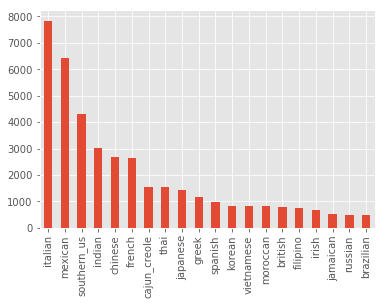

In [153]:
trainData['cuisine'].value_counts().plot(kind='bar')

Creating a table showing the 10 most common ingredients for each cuisine.

In [182]:
from collections import Counter

counters = {}
for cuisine in trainData['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (trainData['cuisine'] == cuisine)
    for ingredients in trainData[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [183]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

top1        top2               top3  \
greek               salt   olive oil        lemon juice   
southern_us         salt         egg             butter   
filipino            salt      garlic              water   
indian              salt       onion             ginger   
jamaican            salt       onion              water   
spanish             salt   olive oil       garlic clove   
italian             salt   olive oil       garlic clove   
mexican             salt       onion             garlic   
chinese        soy sauce      ginger         sesame oil   
british             salt         egg  all purpose flour   
thai          fish sauce  lime juice       coconut milk   
vietnamese    fish sauce       sugar               salt   
cajun_creole        salt       onion             garlic   
brazilian           salt       onion          olive oil   
french              salt       sugar                egg   
japanese       soy sauce        salt              mirin   
irish               salt      butter  all purpose flour   
korean         soy sauce  sesame oil              green   
moroccan            salt   olive oil       ground cumin   
russian             salt         egg              sugar   

                                top4               top5                  top6  \
greek                   garlic clove      dried oregano  feta cheese crumbles   
southern_us        all purpose flour              sugar         baking powder   
filipino                       onion          soy sauce                pepper   
indian                  garam masala              water       ground turmeric   
jamaican                      garlic              thyme       ground allspice   
spanish       extra virgin olive oil              onion                   egg   
italian       grated parmesan cheese             garlic   ground black pepper   
mexican                 ground cumin   chopped cilantro             olive oil   
chinese                         salt        corn starch                 sugar   
british                       butter               milk       unsalted butter   
thai                          garlic               salt             soy sauce   
vietnamese                    garlic              water            lime juice   
cajun_creole       green bell pepper             butter              bay leaf   
brazilian                       lime              water          garlic clove   
french             all purpose flour    unsalted butter             olive oil   
japanese                       sugar              water                ginger   
irish                            egg               milk                 onion   
korean                        garlic              sugar                  salt   
moroccan                       onion       garlic clove       ground cinnamon   
russian                        onion  all purpose flour            sour cream   

                                top7                 top8  \
greek         extra virgin olive oil  ground black pepper   
southern_us                     milk                water   
filipino                         oil                sugar   
indian                        garlic           cumin seed   
jamaican                      pepper             scallion   
spanish                        water               tomato   
italian       extra virgin olive oil                  egg   
mexican                 chili powder           lime juice   
chinese                       garlic                water   
british                        sugar                onion   
thai                    garlic clove        vegetable oil   
vietnamese                    carrot         garlic clove   
cajun_creole               olive oil         garlic clove   
brazilian                     garlic                  egg   
french                        butter         garlic clove   
japanese                        sake         rice vinegar   
irish                          sugar     

We can see from the above that the presence of salt tells us very little, but something like fish sauce can narrow down the probable cuisines considerably. To see how big this effect is, we visualise the percentage of recipes that our most common ingredients are found in, for each cuisine.

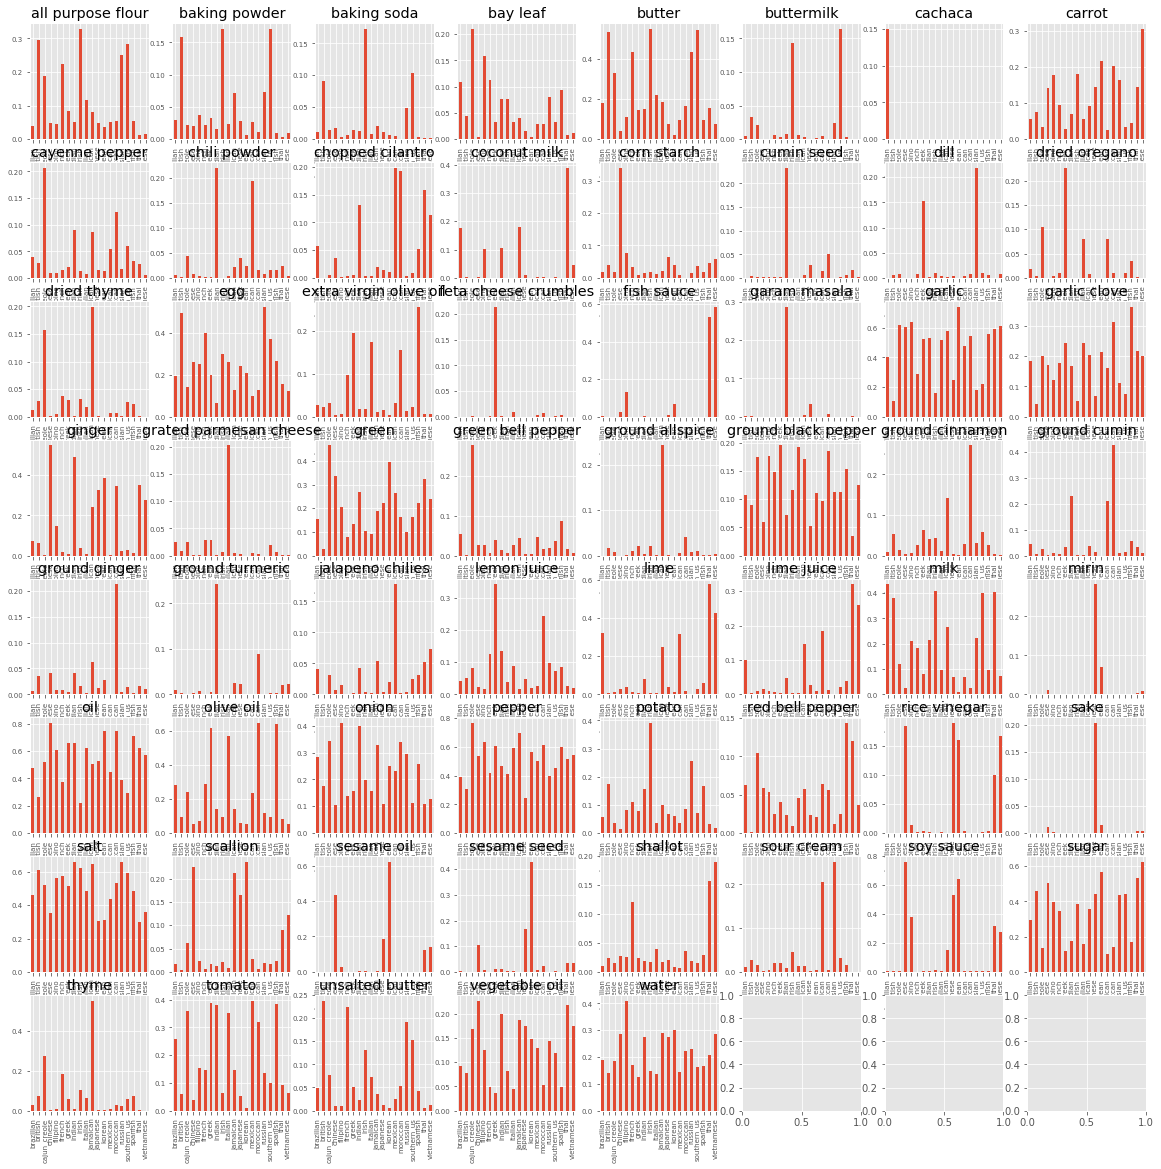

In [18]:
import numpy as np

unique = np.unique(top10.values.ravel())
#trainData['all_ingredients'] = trainData['ingredients'].map(";".join)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = trainData['all_ingredients'].str.contains(ingredient)
    #indices = any(ingredient in s for s in trainData['ingredients'])
    relative_freq = (trainData[indices]['cuisine'].value_counts() / trainData['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)


This indicates the above statement in a more understandable form - ingredients like water, butter and oil don't do much to differentiate between cuisines, whereas sake, feta cheese and garam masala are exceptionally informative.

This is, perhaps, not too surprising, and does indicate that a Naive Bayes classifier should perform very well on this dataset. 

### Section 3: Classifier Implementation

On the single fold of data tested (seed=37), the six classifiers implemented below achieved the following accuracy. Benchmarks are shown in brackets:

**KNN** - 64.44% *(60.75)* <br>
**Decision Tree** - 63.78% *(62.59)* <br>
**Naive Bayes** - 72.57% *(73.25)* <br>
**Random Forest** - 71.16% *(74.13)* <br>
**Logistic Regression** - 78.37% *(81.25)* <br>
**SVM (LinearSVC)** - 77.05% *(81.32)* <br>

For reference, on the test set a score of 82.07% would have been sufficient for a Top-10 placement, while the competition winner scored 83.02%.

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(trainData['all_ingredients'], trainData['cuisine'], test_size=0.2, random_state=37)

In [185]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train.values)
X_test_vec = cv.transform(X_test.values)
X_train_vec.shape
#X_test_vec.shape

(31819, 2682)

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer

#cv = TfidfVectorizer()
#X_train_vec = cv.fit_transform(X_train.values)
#X_test_vec = cv.transform(X_test.values)
#X_train_vec.shape

(31819, 2682)

In [170]:
print(list(cv.vocabulary_.keys())[:100])

['tomato', 'sauce', 'ground', 'black', 'pepper', 'garlic', 'scallion', 'chipotle', 'in', 'adobo', 'avocado', 'dried', 'thyme', 'instant', 'white', 'rice', 'cilantro', 'leaf', 'coconut', 'milk', 'water', 'red', 'bean', 'chopped', 'celery', 'skinless', 'chicken', 'thigh', 'onion', 'lime', 'zest', 'juice', 'wedge', 'salt', 'carrot', 'coarse', 'mint', 'soy', 'freshly', 'clarified', 'butter', 'phyllo', 'dough', 'baby', 'spinach', 'parsley', 'olive', 'oil', 'long', 'grain', 'solid', 'tuna', 'feta', 'cheese', 'crumbles', 'pinenuts', 'linguine', 'basil', 'extra', 'virgin', 'sun', 'clove', 'balsamic', 'vinegar', 'bell', 'bay', 'purple', 'flake', 'arugula', 'shelled', 'pistachio', 'sea', 'bacon', 'diced', 'artichoke', 'heart', 'pitted', 'rosemary', 'boneless', 'breast', 'brown', 'sugar', 'flour', 'tortilla', 'whole', 'kernel', 'corn', 'drain', 'finely', 'salsa', 'shredded', 'monterey', 'jack', 'frozen', 'wish', 'bone', 'guacamol', 'ranch', 'dress', 'grape']


The below encodes the labels, mapping brazilian:vietnamese -> 0:19

In [171]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y_train_vec = enc.fit_transform(y_train.values)
y_test_vec = enc.transform(y_test.values)
y_train_vec[:100]

array([10,  6,  9,  6,  9,  9, 13, 13,  9,  9,  9, 16, 17, 18,  9,  9,  5,
       13, 13, 16, 10, 13, 18, 10, 18,  9, 13, 16, 13,  7, 16,  7,  9, 14,
       13,  3, 13,  4, 16,  9,  7,  9,  4, 18, 13, 12, 13, 11,  9,  9, 14,
        9, 13,  6, 11,  6,  8, 13, 13,  5,  9, 16,  7, 13, 17,  5, 18,  9,
       16,  3,  5, 13, 13,  3,  9,  7,  3,  2,  7, 13,  9, 13, 16,  8, 16,
        9, 14, 11, 13,  9, 16,  2, 17, 13,  9,  7,  9, 11, 16,  9], dtype=int64)

Lastly it's worth checking our validation fold has a representative number of each cuisine in the set. We will of course perform later refolding and validation, but don't want to invalidate the results we'll be commenting on. The graph appears to be showing roughly the same proportions as present in the initial trainData set, so we can proceed.

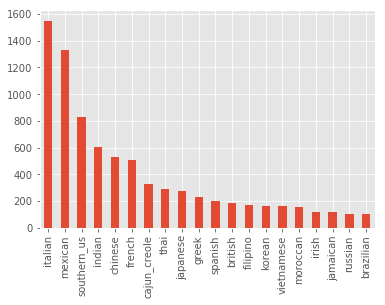

In [172]:
y_test.value_counts().plot(kind='bar')

#### Section 3.1: KNN Classifer

In [87]:
from sklearn.neighbors import KNeighborsClassifier


neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train_vec, y_train_vec)

neigh.score(X_test_vec, y_test_vec)

0.74808296668761787

In [88]:
neigh_pred = neigh.predict(X_test_vec)
print(classification_report(y_test_vec, neigh_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.67      0.60      0.63       102
     british       0.54      0.37      0.44       184
cajun_creole       0.69      0.70      0.70       327
     chinese       0.71      0.85      0.78       529
    filipino       0.71      0.54      0.61       171
      french       0.54      0.60      0.57       508
       greek       0.72      0.63      0.67       229
      indian       0.85      0.86      0.85       605
       irish       0.61      0.54      0.57       121
     italian       0.75      0.88      0.81      1550
    jamaican       0.79      0.58      0.67       117
    japanese       0.82      0.64      0.72       276
      korean       0.77      0.70      0.73       165
     mexican       0.86      0.88      0.87      1331
    moroccan       0.79      0.70      0.74       152
     russian       0.72      0.28      0.40       104
 southern_us       0.70      0.75      0.72       828
     spanish       0.70    

#### Section 3.2: Decision Tree Classifer

In [89]:
from sklearn import tree

dec = tree.DecisionTreeClassifier(max_depth=450, max_features=2420)
dec.fit(X_train_vec, y_train_vec)

dec.score(X_test_vec, y_test_vec)

0.62966687617850403

In [90]:
from sklearn.model_selection import GridSearchCV

def DecisionTree_():
    pipe = Pipeline([('classifier',DecisionTreeClassifier())])
    hyperparameter_space = [{'classifier': [DecisionTreeClassifier()],
    'classifier__max_depth':[x for x in range(200,2001,50)], #}] # best at 90 and 210?
    'classifier__max_features':[i for i in range(2400,2681,20)]}] 
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train_vec, y_train_vec)
    
    return print("Best parameters:\n{}\n".format(grid.best_params_),
                "Best score : {}\n".format(grid.best_score_),
                "Test score : {}".format(grid.score(X_test_vec, y_test_vec)))

In [91]:
#%%time
#DT = DecisionTree_()

In [92]:
dec_pred = dec.predict(X_test_vec)
print(classification_report(y_test_vec, dec_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.43      0.45      0.44       102
     british       0.38      0.29      0.33       184
cajun_creole       0.60      0.53      0.56       327
     chinese       0.66      0.67      0.67       529
    filipino       0.46      0.40      0.43       171
      french       0.40      0.45      0.42       508
       greek       0.53      0.52      0.53       229
      indian       0.76      0.77      0.77       605
       irish       0.36      0.37      0.37       121
     italian       0.72      0.75      0.74      1550
    jamaican       0.53      0.46      0.49       117
    japanese       0.59      0.53      0.56       276
      korean       0.52      0.56      0.54       165
     mexican       0.82      0.83      0.82      1331
    moroccan       0.50      0.51      0.50       152
     russian       0.24      0.19      0.21       104
 southern_us       0.57      0.58      0.57       828
     spanish       0.36    

Code courtesy of Stack Overflow - aim is to convert the above decision tree into a pythonic if-else statement so we can examine the decisions being made. Output is considerably too lengthy for easy reading, but we can see the low entropy of outputs at nearly all of the leaf nodes, indicating this tree is probably overfitting.

In [93]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [130]:
enc.inverse_transform(17)

'spanish'

In [94]:
tree_to_code(dec,cv.get_feature_names())

def tree(abalone, abbamele, absinthe, abura, acai, accent, achiote, acid, acinus, ackee, acorn, acting, activ, active, added, adobo, adzuki, agar, agave, age, aged, ahi, ai, aioli, ajinomoto, ajwain, aka, alaskan, albacore, alcohol, ale, aleppo, alexia, alfalfa, alfredo, all, allspice, almond, almondmilk, aloe, alphabet, alum, amaranth, amaretti, amaretto, amba, amber, amberjack, amchur, america, american, amino, ammonium, amontillado, ampalaya, an, anaheim, anasazi, ancho, anchovy, and, andouille, anejo, angel, anglaise, angled, angostura, angus, anise, anisette, anjou, annatto, ao, aonori, apple, applesauce, applewood, apricot, aquavit, arak, arame, arbol, arborio, arctic, arepa, arhar, armagnac, arrabbiata, arrow, arrowroot, artichok, artichoke, artisan, arugula, asada, asadero, asafetida, asafoetida, ascorbic, asiago, asian, asparagus, aspic, assam, assorted, asti, atar, atta, au, avocado, azteca, azuki, aâ, aã, baby, bacardi, back, bacon, bag, bagel, baguette, bai, bailey, baked, 

#### Section 3.3: Naive Bayes Classifer

In [186]:
from sklearn.naive_bayes import MultinomialNB

bayes = MultinomialNB(alpha=0.3)
#todense() method used to coerce ndarray from csr (sparse) to dense format
#only seemed to be throwing errors on the training matrix, unsure why
bayes.fit(X_train_vec.todense(), y_train_vec)

bayes.score(X_test_vec.todense(), y_test_vec)

0.7327467001885607

In [96]:
def MultinomialNB_():
    pipe = Pipeline([('classifier',MultinomialNB())])
    hyperparameter_space = [{'classifier': [MultinomialNB()],
    'classifier__alpha':[i for i in range(0.1,3.1,0.1)]}] 
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train_vec, y_train_vec)
    
    return print("Best parameters:\n{}\n".format(grid.best_params_),
                "Best score : {}\n".format(grid.best_score_),
                "Test score : {}".format(grid.score(X_test_vec, y_test_vec)))

In [97]:
#%%time
#MNB = MultinomialNB_()

In [187]:
bayes_pred = bayes.predict(X_test_vec.todense())
print(classification_report(y_test_vec, bayes_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.53      0.47      0.50       102
     british       0.32      0.43      0.37       184
cajun_creole       0.60      0.78      0.68       327
     chinese       0.79      0.84      0.81       529
    filipino       0.77      0.61      0.68       171
      french       0.54      0.51      0.52       508
       greek       0.66      0.69      0.68       229
      indian       0.86      0.86      0.86       605
       irish       0.48      0.55      0.51       121
     italian       0.86      0.77      0.81      1550
    jamaican       0.75      0.64      0.69       117
    japanese       0.86      0.64      0.73       276
      korean       0.75      0.78      0.77       165
     mexican       0.92      0.86      0.89      1331
    moroccan       0.66      0.82      0.74       152
     russian       0.52      0.45      0.48       104
 southern_us       0.62      0.71      0.66       828
     spanish       0.45    

In [188]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-15:]
        print("%s: %s" % (class_label,
              "; ".join(feature_names[j] for j in top10)))
        
def print_bottom10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:10]
        print("%s: %s" % (class_label,
              "; ".join(feature_names[j] for j in top10)))
        
print_top10(cv, bayes, [enc.inverse_transform(x) for x in range(20)])
#print_bottom10(cv, bayes, [enc.inverse_transform(x) for x in range(20)])

brazilian: leaf; juice; tomato; onion; black; olive; ground; coconut; sugar; lime; salt; garlic; milk; oil; pepper
british: powder; unsalted; baking; oil; purpose; all; cream; pepper; milk; ground; salt; egg; butter; sugar; flour
cajun_creole: rice; chopped; red; seasoning; celery; tomato; ground; sauce; bell; salt; chicken; oil; green; garlic; pepper
chinese: vinegar; salt; starch; green; corn; rice; chicken; sugar; ginger; sesame; garlic; pepper; soy; oil; sauce
filipino: egg; black; milk; pork; ground; chicken; soy; onion; water; sugar; salt; oil; pepper; garlic; sauce
french: wine; cream; leaf; black; garlic; flour; white; ground; olive; oil; sugar; butter; salt; egg; pepper
greek: clove; black; oregano; dried; juice; feta; tomato; salt; cheese; garlic; ground; lemon; oil; pepper; olive
indian: masala; cilantro; leaf; coriander; onion; tomato; powder; ginger; cumin; pepper; garlic; seed; salt; oil; ground
irish: powder; oil; cream; milk; egg; purpose; all; ground; baking; potato; p

#### Section 3.4: Random Forest Classifer

In [99]:
from sklearn.ensemble import RandomForestClassifier

frst = RandomForestClassifier(random_state=37, n_estimators=151, max_depth=450)
frst.fit(X_train_vec, y_train_vec)

frst.score(X_test_vec, y_test_vec)

0.75235700817096163

In [100]:
frst_pred = frst.predict(X_test_vec)
print(classification_report(y_test_vec, frst_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.87      0.45      0.59       102
     british       0.69      0.18      0.28       184
cajun_creole       0.83      0.71      0.77       327
     chinese       0.71      0.87      0.78       529
    filipino       0.86      0.47      0.61       171
      french       0.58      0.53      0.55       508
       greek       0.84      0.56      0.68       229
      indian       0.82      0.88      0.85       605
       irish       0.71      0.37      0.49       121
     italian       0.71      0.93      0.81      1550
    jamaican       0.97      0.52      0.68       117
    japanese       0.83      0.62      0.71       276
      korean       0.91      0.65      0.76       165
     mexican       0.85      0.93      0.89      1331
    moroccan       0.86      0.67      0.76       152
     russian       0.89      0.24      0.38       104
 southern_us       0.62      0.78      0.69       828
     spanish       0.87    

#### Section 3.5: Logistic Regression Classifer

In [101]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_vec, y_train_vec)

logistic.score(X_test_vec, y_test_vec)

0.77347580138277816

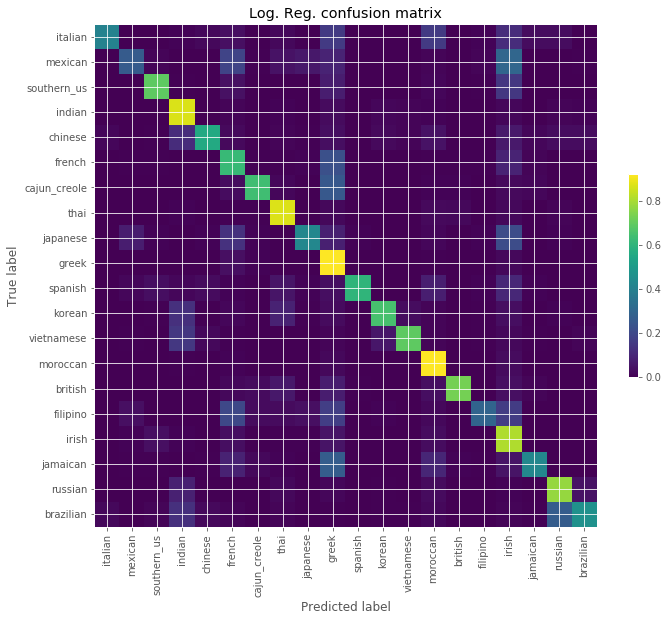

In [102]:
plt.figure(figsize=(10, 10))

log_cm = confusion_matrix(y_test_vec, logistic.predict(X_test_vec))
log_cm_normalized = log_cm.astype('float') / log_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(log_cm_normalized, interpolation='nearest')
plt.title("Log. Reg. confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = trainData['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [103]:
log_pred = logistic.predict(X_test_vec)
print(classification_report(y_test_vec, log_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.84      0.41      0.55       102
     mexican       0.64      0.27      0.38       184
 southern_us       0.81      0.70      0.75       327
      indian       0.76      0.87      0.81       529
     chinese       0.83      0.56      0.67       171
      french       0.57      0.62      0.60       508
cajun_creole       0.80      0.64      0.71       229
        thai       0.86      0.88      0.87       605
    japanese       0.68      0.43      0.53       121
       greek       0.76      0.92      0.83      1550
     spanish       0.93      0.61      0.74       117
      korean       0.85      0.66      0.74       276
  vietnamese       0.86      0.70      0.77       165
    moroccan       0.90      0.92      0.91      1331
     british       0.85      0.73      0.78       152
    filipino       0.67      0.30      0.41       104
       irish       0.66      0.81      0.73       828
    jamaican       0.73    

Although the raw accuracy score looks good, the confusion matrix and particularly the analysis of the recall show a different story for some cuisines. Italian, Mexican and Filipino dishes are more likely to be classified as other cuisines than they are themselves, indicating that there may be few stand-out ingredients for these cuisines.

#### Section 3.6: SVM Classifer

In [104]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state=37, C=0.38, penalty='l2',dual=False)
lsvc.fit(X_train_vec, y_train_vec)

lsvc.score(X_test_vec, y_test_vec)

0.79032055311125082

In [105]:
def LinearSVC_():
    pipe = Pipeline([('classifier',LinearSVC(dual=False))])
    hyperparameter_space = [{'classifier': [LinearSVC(dual=False)],
    'classifier__penalty':['l1','l2'], #}] # best at 90 and 210?
    'classifier__C':[i/30 for i in range(1,31,1)]}] 
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train_vec, y_train_vec)
    
    return print("Best parameters:\n{}\n".format(grid.best_params_),
                "Best score : {}\n".format(grid.best_score_),
                "Test score : {}".format(grid.score(X_test_vec, y_test_vec)))

In [106]:
#%%time
#SVM = LinearSVC_()

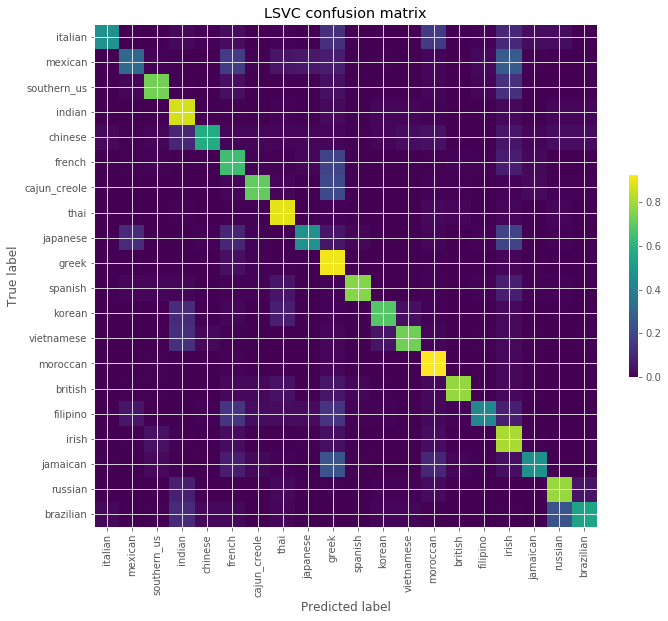

In [107]:
plt.figure(figsize=(10, 10))

lsvc_cm = confusion_matrix(y_test_vec, lsvc.predict(X_test_vec))
lsvc_cm_normalized = lsvc_cm.astype('float') / lsvc_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(lsvc_cm_normalized, interpolation='nearest')
plt.title("LSVC confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = trainData['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [108]:
lsvc_pred = lsvc.predict(X_test_vec)
print(classification_report(y_test_vec, lsvc_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.79      0.47      0.59       102
     british       0.59      0.32      0.42       184
cajun_creole       0.79      0.74      0.76       327
     chinese       0.77      0.87      0.82       529
    filipino       0.86      0.57      0.69       171
      french       0.61      0.64      0.63       508
       greek       0.78      0.71      0.74       229
      indian       0.87      0.89      0.88       605
       irish       0.62      0.47      0.54       121
     italian       0.80      0.91      0.85      1550
    jamaican       0.87      0.76      0.81       117
    japanese       0.86      0.68      0.76       276
      korean       0.79      0.73      0.76       165
     mexican       0.90      0.93      0.92      1331
    moroccan       0.84      0.78      0.81       152
     russian       0.69      0.43      0.53       104
 southern_us       0.70      0.81      0.75       828
     spanish       0.68    

#### Section 3.7: Multi-layer perceptron

In [109]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(3000), random_state=37, early_stopping=True, solver='adam', verbose=True)
mlp.fit(X_train_vec, y_train_vec)

Iteration 1, loss = 1.23840495
Validation score: 0.770585
Iteration 2, loss = 0.63354712
Validation score: 0.781898
Iteration 3, loss = 0.53369492
Validation score: 0.779384
Iteration 4, loss = 0.47085928
Validation score: 0.781270
Iteration 5, loss = 0.42534015
Validation score: 0.780327
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=3000, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=37, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [110]:
mlp.score(X_test_vec, y_test_vec)

0.78340666247642987

In [111]:
mlp.coefs_[0].shape

(2682, 3000)

In [112]:
mlp_pred = mlp.predict(X_test_vec)
print(classification_report(y_test_vec, mlp_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.70      0.53      0.60       102
     british       0.55      0.45      0.49       184
cajun_creole       0.80      0.70      0.75       327
     chinese       0.84      0.81      0.83       529
    filipino       0.67      0.65      0.66       171
      french       0.57      0.69      0.62       508
       greek       0.66      0.74      0.70       229
      indian       0.88      0.87      0.87       605
       irish       0.73      0.49      0.58       121
     italian       0.81      0.89      0.85      1550
    jamaican       0.90      0.67      0.76       117
    japanese       0.76      0.75      0.76       276
      korean       0.84      0.70      0.76       165
     mexican       0.91      0.92      0.92      1331
    moroccan       0.78      0.80      0.79       152
     russian       0.57      0.45      0.50       104
 southern_us       0.74      0.78      0.76       828
     spanish       0.73    

#### Section 3.8: XGBoost

In [113]:
import xgboost as xgb

xgb = xgb.XGBClassifier()
grid = {'max_depth':1000,'n_estimators':425}
xgb.set_params(**grid)
xgb.fit(X_train_vec, y_train_vec)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=425, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [114]:
def XGBoost_():
    pipe = Pipeline([('classifier', xgb.XGBClassifier())])    
    hyperparameter_space = [{'classifier': [xgb.XGBClassifier()],
                             'classifier__max_depth': [x for x in range(1,1001,200)],
                             'classifier__n_estimators' : [x for x in range(1,1001,200)]}]
    grid = GridSearchCV(pipe, hyperparameter_space, cv=3)
    grid.fit(X_train, y_train)

In [115]:
#%%time
#XGB = XGBoost_()

In [116]:
xgb.score(X_test_vec, y_test_vec)

0.78152105593966059

In [117]:
xgb_pred = xgb.predict(X_test_vec)
print(classification_report(y_test_vec, xgb_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.78      0.64      0.70       102
     british       0.71      0.39      0.50       184
cajun_creole       0.79      0.76      0.77       327
     chinese       0.77      0.84      0.81       529
    filipino       0.76      0.61      0.68       171
      french       0.61      0.61      0.61       508
       greek       0.79      0.68      0.73       229
      indian       0.85      0.88      0.86       605
       irish       0.65      0.55      0.59       121
     italian       0.80      0.90      0.84      1550
    jamaican       0.84      0.69      0.76       117
    japanese       0.77      0.66      0.71       276
      korean       0.81      0.73      0.77       165
     mexican       0.90      0.92      0.91      1331
    moroccan       0.77      0.76      0.77       152
     russian       0.54      0.39      0.46       104
 southern_us       0.70      0.79      0.74       828
     spanish       0.72    

#### Section 3.9: Ensemble voting

In [131]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

#80.11 with just best 3
#80.03 with best 5
#79.70 with best 4 (inc. SVM)
#79.42 with just xgb, mlp
estimators = []
estimators.append(('logistic',logistic))
estimators.append(('svm', lsvc))
estimators.append(('xgb', xgb))
estimators.append(('mlp', mlp))
estimators.append(('frst', frst))
estimators.append(('knn', neigh))
#estimators.append(('MNNB', bayes))

ens = VotingClassifier(estimators)
ens.fit(X_train_vec, y_train_vec)
ens.score(X_test_vec, y_test_vec)

Iteration 1, loss = 1.23840495
Validation score: 0.770585
Iteration 2, loss = 0.63354712
Validation score: 0.781898
Iteration 3, loss = 0.53369492
Validation score: 0.779384
Iteration 4, loss = 0.47085928
Validation score: 0.781270
Iteration 5, loss = 0.42534015
Validation score: 0.780327
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [119]:
print(ens.weights)

None


In [120]:
ens_pred = ens.predict(X_test_vec)
print(classification_report(y_test_vec, ens_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.81      0.51      0.63       102
     british       0.63      0.35      0.45       184
cajun_creole       0.82      0.74      0.78       327
     chinese       0.77      0.89      0.82       529
    filipino       0.82      0.61      0.70       171
      french       0.59      0.65      0.62       508
       greek       0.80      0.69      0.74       229
      indian       0.87      0.89      0.88       605
       irish       0.71      0.49      0.58       121
     italian       0.78      0.92      0.85      1550
    jamaican       0.94      0.68      0.79       117
    japanese       0.86      0.68      0.76       276
      korean       0.87      0.72      0.78       165
     mexican       0.91      0.93      0.92      1331
    moroccan       0.83      0.77      0.80       152
     russian       0.69      0.39      0.50       104
 southern_us       0.71      0.82      0.76       828
     spanish       0.79    

#### Bonus section: implementing pipelines from andrew_bag_of_words to compare results

In [121]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   n_iter=5,
                                                   random_state=42)),
                         ])

text_clf_svm.fit(X_train, y_train)
text_clf_svm.score(X_test, y_test)


C:\Apps\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.707605279698303

In [122]:
pipe_svm_pred = text_clf_svm.predict(X_test)
print(classification_report(y_test, pipe_svm_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       0.68      0.25      0.37       102
     british       0.66      0.10      0.18       184
cajun_creole       0.70      0.67      0.68       327
     chinese       0.64      0.88      0.74       529
    filipino       0.88      0.26      0.41       171
      french       0.61      0.37      0.46       508
       greek       0.77      0.55      0.64       229
      indian       0.75      0.89      0.81       605
       irish       0.56      0.23      0.33       121
     italian       0.68      0.93      0.79      1550
    jamaican       0.81      0.48      0.60       117
    japanese       0.80      0.61      0.69       276
      korean       0.79      0.45      0.58       165
     mexican       0.82      0.93      0.87      1331
    moroccan       0.82      0.53      0.64       152
     russian       0.62      0.28      0.38       104
 southern_us       0.62      0.75      0.68       828
     spanish       0.63    

In [123]:
from sklearn.multiclass import OneVsRestClassifier

pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', OneVsRestClassifier(MultinomialNB()))])

pipe_nb.fit(X_train, y_train)
pipe_nb.score(X_test,y_test)

0.67743557510999375

In [124]:
pipe_nb_pred = pipe_nb.predict(X_test)
print(classification_report(y_test, pipe_nb_pred, target_names=enc.inverse_transform([x for x in range(20)])))

              precision    recall  f1-score   support

   brazilian       1.00      0.19      0.31       102
     british       0.79      0.08      0.15       184
cajun_creole       0.80      0.51      0.62       327
     chinese       0.59      0.91      0.72       529
    filipino       0.95      0.11      0.19       171
      french       0.55      0.43      0.48       508
       greek       0.86      0.35      0.50       229
      indian       0.76      0.89      0.82       605
       irish       0.93      0.12      0.21       121
     italian       0.66      0.91      0.76      1550
    jamaican       0.96      0.21      0.35       117
    japanese       0.94      0.57      0.71       276
      korean       0.95      0.36      0.52       165
     mexican       0.81      0.92      0.86      1331
    moroccan       0.93      0.34      0.50       152
     russian       1.00      0.02      0.04       104
 southern_us       0.49      0.80      0.61       828
     spanish       0.93    

This is actually the most interesting result so far. The high precision and horrendous recall on Brazilian, Filipino, Jamaican, Russian, Spanish and Vietnames suggest that the classifier is barely predicting these cuisines at all. That said, the f-score is very high for other cuisines such as Indian, Italian, Japanese and Mexican, suggesting that this could be used as part of a One vs All classifier ensemble, specifically for dealing with those cuisines.

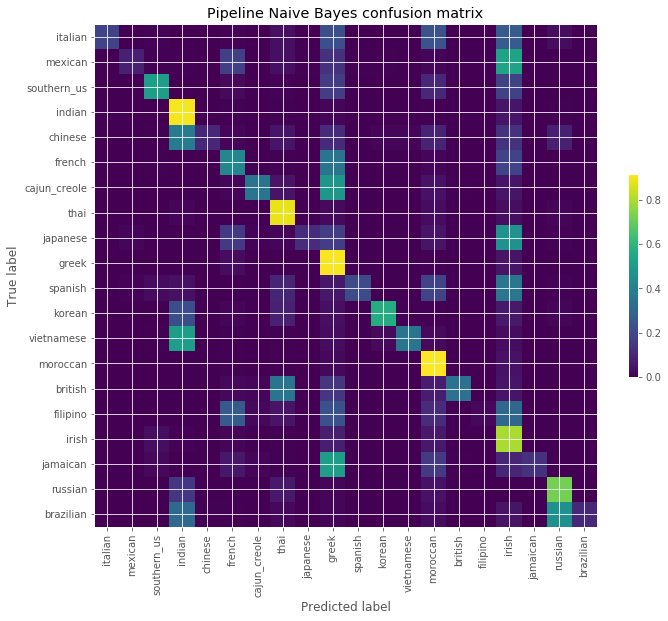

In [125]:
plt.figure(figsize=(10, 10))

pipe_nb_cm = confusion_matrix(y_test, pipe_nb.predict(X_test))
pipe_nb_cm_normalized = pipe_nb_cm.astype('float') / pipe_nb_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(pipe_nb_cm_normalized, interpolation='nearest')
plt.title("Pipeline Naive Bayes confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = trainData['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')